In [36]:
from statsmodels.regression.rolling import RollingOLS
from joblib import Memory
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
import plotly.graph_objects as go
from scipy.signal import argrelextrema
warnings.filterwarnings("ignore")

cachedir = "./yfinance_cache" 
memory = Memory(cachedir, verbose=0)


@memory.cache
def cached_yf_download(*args, **kwargs):
    return yf.download(*args, **kwargs)


# @memory.cache
def cached_tickers(dt):
    sp500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]
    sp500["Symbol"] = sp500["Symbol"].str.replace(".", "-")
    symbols_list = sp500["Symbol"].unique().tolist()

    QQQ = pd.read_html("https://en.wikipedia.org/wiki/Nasdaq-100#Components")[4]
    QQQ["Ticker"] = QQQ["Ticker"].str.replace(".", "-")
    nasdaq_symbols_list = QQQ["Ticker"].unique().tolist()

    symbols_list.extend(nasdaq_symbols_list)
    symbols_list = list(set(symbols_list))

    return symbols_list


# end_date = '2023-11-21'
end_date = pd.Timestamp.now().floor("5T")

start_date = pd.to_datetime(end_date) - pd.DateOffset(45)

symbols_list = cached_tickers("2023-11-21")

df = cached_yf_download(
    tickers=["SPY","QQQ","GOOG", "NVDA","AMZN","TPR","TGT"], start=start_date, end=end_date,
    interval="15m"
).stack()

df.index.names = ["date", "ticker"]

df.columns = df.columns.str.lower()

df



[*********************100%%**********************]  7 of 7 completed


adj close       close        high         low  \
date                ticker                                                   
2023-10-13 15:15:00 AMZN    129.485001  129.485001  129.789993  129.350296   
                    GOOG    138.600006  138.600006  138.830002  138.509995   
                    NVDA    455.079987  455.079987  456.299988  454.610107   
                    QQQ     364.980011  364.980011  365.459991  364.791290   
                    SPY     431.079987  431.079987  431.690002  430.890015   
...                                ...         ...         ...         ...   
2023-11-27 15:15:00 NVDA    483.480011  483.480011  483.480011  482.436615   
                    QQQ     389.684998  389.684998  389.694000  389.454987   
                    SPY     454.769989  454.769989  454.769989  454.470001   
                    TGT     131.409698  131.409698  131.460007  131.250000   
                    TPR      30.910000   30.910000   30.910000   30.870001   

                                  open   volume  
date                ticker                       
2023-10-13 15:15:00 AMZN    129.705002   430163  
                    GOOG    138.804993   183403  
                    NVDA    455.929993   644923  
                    QQQ     365.399994   494737  
                    SPY     431.570007  1083810  
...                                ...      ...  
2023-11-27 15:15:00 NVDA    482.744995   291907  
                    QQQ     389.484985   623355  
                    SPY     454.510010   402445  
                    TGT     131.339996    41728  
                    TPR      30.895000    30653  

[5383 rows x 6 columns]

In [37]:
def isPivot(data, candle, window):
    """
    function that detects if a candle is a pivot/fractal point
    args: candle index, window before and after candle to test if pivot
    returns: 1 if pivot high, 2 if pivot low, 3 if both and 0 default
    """
    
    if candle-window < 0 or candle+window >= len(data):
        return 0
    
    pivotHigh = 1
    pivotLow = -1
    for i in range(candle-window, candle+window+1):
        if data.iloc[candle].low > data.iloc[i].low:
            pivotLow=0
        if data.iloc[candle].high < data.iloc[i].high:
            pivotHigh=0
    if (pivotHigh and pivotLow):
        return 0
    elif pivotHigh:
        return pivotHigh
    elif pivotLow:
        return pivotLow
    else:
        return 0

def is_between(needle, haystack):
    return abs(needle) > haystack[0] and abs(needle) < haystack[1]
def pointpos(x):
    if x['pivot']==-1:
        return x['low']-1e-3
    elif x['pivot']==1:
        return x['high']+1e-3
    else:
        return np.nan
    
def is_gartley(zigzag, fuzz_factor):
    if len(zigzag) != 5:
        return 0
    XA = zigzag[1]['adj close'] - zigzag[0]['adj close']
    AB = zigzag[2]['adj close'] - zigzag[1]['adj close']
    BC = zigzag[3]['adj close'] - zigzag[2]['adj close']
    CD = zigzag[4]['adj close'] - zigzag[3]['adj close']

    AB_range = [(0.618 - fuzz_factor) * abs(XA), (0.618 + fuzz_factor) * abs(XA)]
    BC_range = [(0.382 - fuzz_factor) * abs(AB), (0.886 + fuzz_factor) * abs(AB)]
    CD_range = [(1.27 - fuzz_factor) * abs(BC), (1.618 + fuzz_factor) * abs(BC)]
    
    has_structure = (
        is_between(AB, AB_range)
        and is_between(BC, BC_range)
        and is_between(CD, CD_range)
    )
    
    bullish = XA > 0 and AB < 0 and BC > 0 and CD < 0
    bearish = XA < 0 and AB > 0 and BC < 0 and CD > 0
    
    if (has_structure and bullish):
        return 1
    elif (has_structure and bearish):
        return -1
    else:
        return 0

In [38]:
def find_extrema(data, order=7):
    adj_close = data['adj close']
    maxima = argrelextrema(adj_close.values, np.greater, order=order)[0]
    minima = argrelextrema(adj_close.values, np.less, order=order)[0]
    return maxima, minima

def apply_extrema(df, order=7, column='adj close'):
    highs = argrelextrema(df[column].values, np.greater, order=order)[0]
    lows = argrelextrema(df[column].values, np.less, order=order)[0]
    
    # Create a new column for the merged signal
    df['pivot'] = 0  # Initialize with 0

    # Assign 1 to maxima and -1 to minima
    df.loc[highs, 'pivot'] = 1
    df.loc[lows, 'pivot'] = -1
    
    return highs, lows



In [39]:
def detect_structure(data, candle, backcandles, harmonic_fn, window=3):
    if (candle <= (backcandles+window)) or (candle+window +1 >= len(data)):
        return 0
    
    localdf = data.iloc[candle-backcandles-window:candle-window] #window must be greater than pivot window to avoid look ahead bias
    localdf.reset_index(drop=True, inplace=True)
    if 'harmonic' not in df.columns:
        localdf['harmonic']=0
        
    localdf['ema8'] = pandas_ta.ema(localdf['adj close'], length=8)

    maxima, minima = apply_extrema(localdf,3)
    
    last_five_extrema = localdf[localdf['pivot']!=0][-5:]
    
    if len(last_five_extrema) != 5:
        return 0
    
    if (last_five_extrema['harmonic'].sum() > 0):
        return 0
    
    if abs(last_five_extrema['pivot'].sum()) != 1:
        return 0
    
    X = last_five_extrema.iloc[0]
    A = last_five_extrema.iloc[1]
    B = last_five_extrema.iloc[2]
    C = last_five_extrema.iloc[3]
    D = last_five_extrema.iloc[4]

    if D["harmonic"] != 0:
        return 0
    current_candle = data.iloc[candle]  
    current_candle_sentiment = 1 if ((current_candle['adj close'] - current_candle['open']) > 0) else -1
    
    hm_sentiment = last_five_extrema['pivot'].sum() * -1
    ema_signal = 1 if current_candle['adj close'] > current_candle['ema'] else -1
    candle_sentiment = 1 if (D['adj close'] - D['open']) > 0 else -1
    
    signal = harmonic_fn([X,A,B,C,D], 5)

    if (signal != 0 and D['pivot'] == -1*signal
        and hm_sentiment == signal
        and ema_signal == hm_sentiment 
#         and ema_signal == candle_sentiment
        and current_candle_sentiment == signal):
#         print ("------------")
#         print (signal, hm_sentiment, ema_signal, candle_sentiment, current_candle_sentiment)
        return signal
    
    return 0

In [42]:
ticker="TGT"
data = df.xs(ticker, level=1).drop_duplicates().tail(100)
data['vwap'] = pandas_ta.vwap(data['high'], data['low'], data['close'], data['volume'])
data = data.reset_index().rename(columns={'index': 'original_index'})
data = data[data["volume"]>0]
data['ema'] = pandas_ta.ema(data['close'], length=8)
data['harmonic'] = data.apply(lambda row: detect_structure(data, row.name, 65, is_gartley), axis=1)
data[data["harmonic"]!=0]

,date,adj close,close,high,low,open,volume,vwap,ema,harmonic


In [33]:

hm = data[data["harmonic"]!=0]
# hm = hm[hm["pivot"] != 0]
hm_bull = hm[hm["harmonic"] == 1]
hm_bear = hm[hm["harmonic"] == -1]
fig = go.Figure(data=[go.Candlestick(x=data.index,
                open=data['open'],
                high=data['high'],
                low=data['low'],
                close=data['adj close'])])

# fig.add_scatter(x=data.index, y=data['pointpos'], mode="markers",
#                 marker=dict(size=5, color="MediumPurple"),
#                 name="pivot")

fig.add_scatter(x=hm_bull.index, y=hm_bull['low']-(hm_bull['low']*.0001), mode="markers",
                marker=dict(size=5, color="yellow"),
                name="Bull Signal")

fig.add_scatter(x=hm_bear.index, y=hm_bear['high']+(hm_bear['high']*.0001), mode="markers",
                marker=dict(size=5, color="blue"),
                name="Bear Signal")

fig.add_trace(go.Scatter(x=data.index, y=data['ema'], mode='lines', name='EMA'))

fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

In [34]:

bt_data = data.copy()
bt_data.rename(columns={
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'volume': 'Volume'
}, inplace=True)

bt_data.set_index("date", inplace=True)
bt_data.index = pd.to_datetime(bt_data.index, format='%d.%m.%Y %H:%M:%S.%f').floor('S')
bt_data

,adj close,Close,High,Low,Open,Volume,vwap,ema,harmonic
date,,,,,,,,,
2023-11-24 10:00:00-05:00,30.395000,30.395000,30.440001,30.340000,30.360001,32465,30.391667,NaN,0
2023-11-24 10:05:00-05:00,30.400000,30.400000,30.440001,30.389999,30.391001,16417,30.397824,NaN,0
2023-11-24 10:10:00-05:00,30.455000,30.455000,30.455000,30.395000,30.400000,30033,30.411972,NaN,0
2023-11-24 10:15:00-05:00,30.490000,30.490000,30.490000,30.459999,30.459999,17988,30.424600,NaN,0
2023-11-24 10:20:00-05:00,30.495001,30.495001,30.520000,30.464199,30.490000,40895,30.444919,NaN,0
...,...,...,...,...,...,...,...,...,...
2023-11-27 14:35:00-05:00,30.940001,30.940001,30.950001,30.904800,30.910000,24015,30.762734,30.927736,0
2023-11-27 14:40:00-05:00,30.879999,30.879999,30.938900,30.860001,30.930000,57372,30.766731,30.917128,0
2023-11-27 14:45:00-05:00,30.860001,30.860001,30.889999,30.855000,30.889999,19188,30.767764,30.904433,0


In [35]:
from backtesting import Strategy
from backtesting import Backtest

def SIGNAL():
    return data.harmonic

class XABCD(Strategy):
    TPSLRatio = 2
    sl_pct = 0.01
    tx_size = .99
    
    def init(self):
        super().init()
        self.signal = self.I(SIGNAL)
       

    def next(self):
        super().next()
        index = len(self.data)-1
    
        for trade in self.trades:
            pct = (self.data.Close[index]-trade.entry_price)/trade.entry_price

            if trade.is_long:
                trade.sl = max(trade.sl, self.data.Close[index]*(1-self.sl_pct))
            if trade.is_short:
                trade.sl = min(trade.sl, self.data.Close[index]*(1+self.sl_pct))
                
        if self.signal!=0 and self.data.harmonic==1 and not self.position.is_long:
            self.position.close()
            sl1 = self.data.Close[-1]-self.data.Close[-1]*self.sl_pct
            sldiff = abs(sl1-self.data.Close[index])
            tp1 = self.data.Close[-1]+sldiff*self.TPSLRatio
            self.buy(sl=sl1, tp=tp1, size=self.tx_size)
            self.buy(sl=sl1, size=self.tx_size)

        elif self.signal!=0 and self.data.harmonic==-1 and not self.position.is_short:
            self.position.close()
            sl1 = self.data.Close[index]+self.data.Close[index]*self.sl_pct
            sldiff = abs(sl1-self.data.Close[index])
            tp1 = self.data.Close[index]-sldiff*self.TPSLRatio
            self.sell(sl=sl1, tp=tp1, size=self.tx_size)
            self.sell(sl=sl1, size=self.tx_size)

bt = Backtest(bt_data, XABCD, cash=10000, margin=1/5)
stat = bt.run()
bt.plot()
# stat


GridPlot(id='p2053', ...)

In [884]:

bt_results={}

# Iterate through each ticker
for ticker in df.index.get_level_values(1).unique():
    data = df.xs(ticker, level=1).drop_duplicates()
    data = data.reset_index().rename(columns={'index': 'original_index'})
    data = data[data["volume"]>0]
    data['ema'] = pandas_ta.ema(data['close'], length=8)
    data['harmonic'] = data.apply(lambda row: detect_structure(data, row.name, 65, is_gartley), axis=1)

    bt_data = data.copy()
    bt_data.rename(columns={
        'open': 'Open',
        'high': 'High',
        'low': 'Low',
        'close': 'Close',
        'volume': 'Volume'
    }, inplace=True)

    bt_data.set_index("date", inplace=True)
    bt_data.index = pd.to_datetime(bt_data.index, format='%d.%m.%Y %H:%M:%S.%f').floor('S')

    bt = Backtest(bt_data, XABCD, cash=10000, margin=1/5)
    bt_result = bt.run()
    bt_results[ticker]=bt_result
    
results_df = pd.DataFrame(bt_results).T  # Transpose to get strategies as rows
print(results_df)


                          Start                        End           Duration  \
AMZN  2021-12-06 12:30:00-05:00  2023-11-24 11:30:00-05:00  717 days 23:00:00   
GOOG  2021-12-06 12:30:00-05:00  2023-11-24 11:30:00-05:00  717 days 23:00:00   
NVDA  2021-12-06 12:30:00-05:00  2023-11-24 11:30:00-05:00  717 days 23:00:00   
QQQ   2021-12-06 12:30:00-05:00  2023-11-24 11:30:00-05:00  717 days 23:00:00   
SPY   2021-12-06 12:30:00-05:00  2023-11-24 11:30:00-05:00  717 days 23:00:00   
ARM   2023-09-14 11:30:00-04:00  2023-11-24 11:30:00-05:00   71 days 01:00:00   

     Exposure Time [%]   Equity Final [$]    Equity Peak [$]      Return [%]  \
AMZN         36.082176  1543556469.189046  1620729906.901692  15435464.69189   
GOOG         33.873301     1528508.746498     1532333.387518    15185.087465   
NVDA         28.232572     8621979.265356     8734690.367651    86119.792654   
QQQ          38.993347     2176048.589598     2382476.456053    21660.485896   
SPY          47.176368     96347

In [886]:
results_df.to_csv("out.csv") 

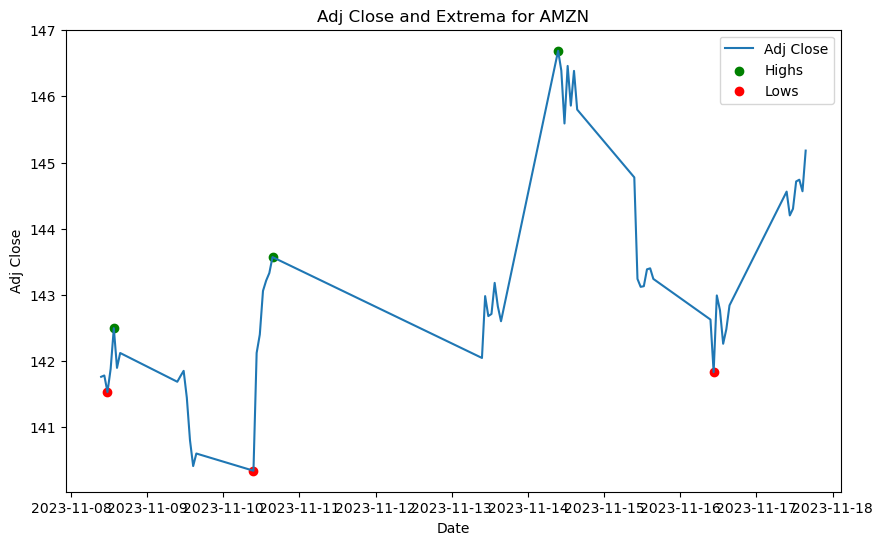

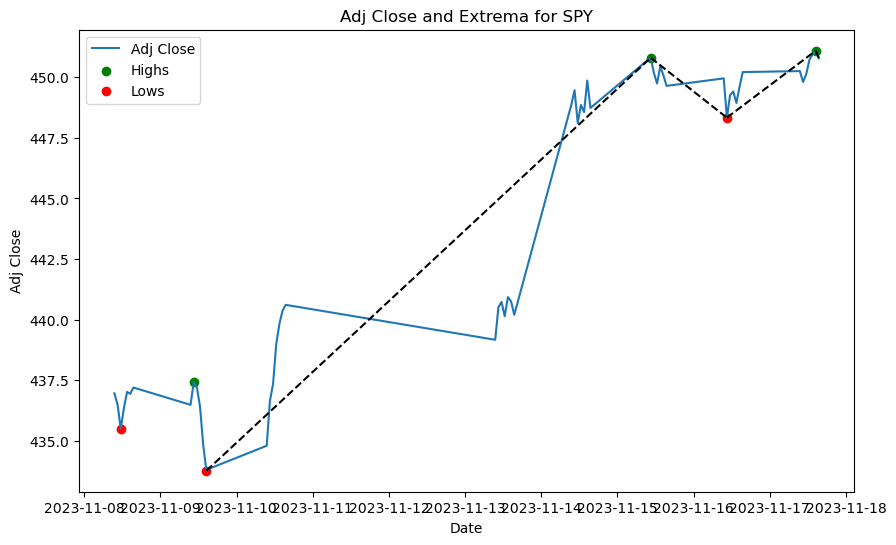

In [130]:
for ticker in df.index.get_level_values(1).unique():
    data = df.xs(ticker, level=1).drop_duplicates().tail(100)  # Get the last 100 rows for the ticker
    maxima, minima = find_extrema(data)
    extrema_indices = np.sort(np.concatenate((maxima, minima, [len(data)-1])))
    prices = data['adj close'].values
    
    # Select only the last 5 extrema points
    last_five_extrema = extrema_indices[-5:]
    
    current_idx = extrema_indices[-5:]
    current_pattern = prices[current_idx]

    XA = current_pattern[1] - current_pattern[0]
    AB = current_pattern[2] - current_pattern[1]
    BC = current_pattern[3] - current_pattern[2]
    CD = current_pattern[4] - current_pattern[3]

    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['adj close'], label='Adj Close')

    # Plot highs in green and lows in red
    plt.scatter(data.iloc[maxima].index, data.iloc[maxima]['adj close'], color='green', label='Highs')
    plt.scatter(data.iloc[minima].index, data.iloc[minima]['adj close'], color='red', label='Lows')

    if (XA > 0 and AB < 0 and BC > 0 and CD < 0):
    # Draw lines between the last 5 extrema
        for i in range(len(last_five_extrema) - 1):
            plt.plot([data.index[last_five_extrema[i]], data.index[last_five_extrema[i + 1]]],
                     [data['adj close'][last_five_extrema[i]], data['adj close'][last_five_extrema[i + 1]]],
                     color='black', linestyle='--')
    
    plt.title(f'Adj Close and Extrema for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Adj Close')
    plt.legend()
    plt.show()

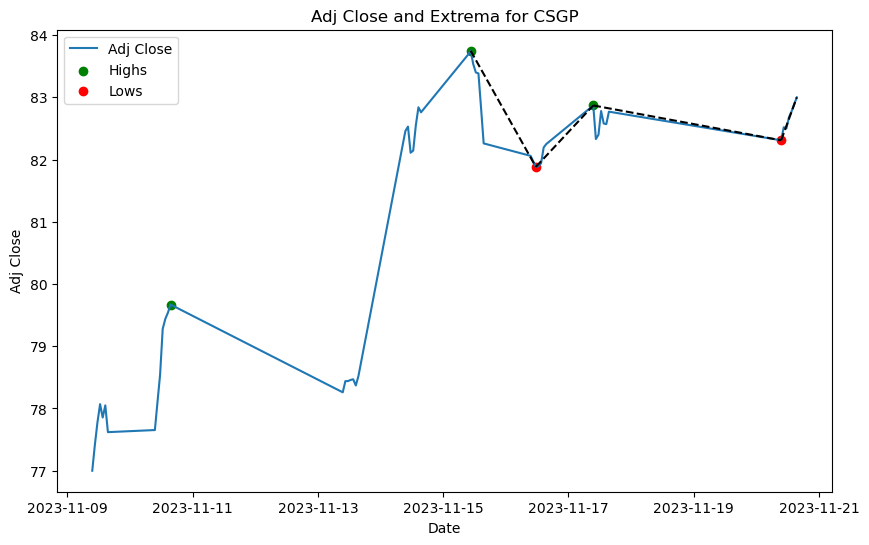

In [261]:
fuzz_factor = float(10.0/100)

def is_between(needle, haystack):
    return abs(needle) > haystack[0] and abs(needle) < haystack[1]

def is_gartley(zigzag, fuzz):
    XA = zigzag[0]
    AB = zigzag[1]
    BC = zigzag[2]
    CD = zigzag[3]
    
    AB_range = [(0.618-fuzz_factor)*abs(XA), (0.618+fuzz_factor)*abs(XA)]
    BC_range = [(0.382-fuzz_factor)*abs(AB), (0.886+fuzz_factor)*abs(AB)]
    CD_range = [(1.27-fuzz_factor)*abs(BC), (1.618+fuzz_factor)*abs(BC)]

    result = is_between(AB, AB_range) and is_between(BC, BC_range) and is_between(CD, CD_range)
    
    return result

for ticker in df.index.get_level_values(1).unique():
    data = df.xs(ticker, level=1).drop_duplicates().tail(100)  # Get the last 100 rows for the ticker
    maxima, minima = find_extrema(data)
    extrema_indices = np.sort(np.concatenate((maxima, minima, [len(data)-1])))
    prices = data['adj close'].values
    
    # Select only the last 5 extrema points
    last_five_extrema = extrema_indices[-5:]
    
    if len(last_five_extrema) < 5:
        continue
    
    current_idx = extrema_indices[-5:]
    current_pattern = prices[current_idx]

    XA = current_pattern[1] - current_pattern[0]
    AB = current_pattern[2] - current_pattern[1]
    BC = current_pattern[3] - current_pattern[2]
    CD = current_pattern[4] - current_pattern[3]
    
    bullish = XA > 0 and AB < 0 and BC > 0 and CD < 0
    bearish = XA < 0 and AB > 0 and BC < 0 and CD > 0

    if (bullish or bearish):
        zigzag = [XA, AB, BC, CD]
        
        if is_gartley(zigzag, fuzz_factor):
            plt.figure(figsize=(10, 6))
            plt.plot(data.index, data['adj close'], label='Adj Close')

            # Plot highs in green and lows in red
            plt.scatter(data.iloc[maxima].index, data.iloc[maxima]['adj close'], color='green', label='Highs')
            plt.scatter(data.iloc[minima].index, data.iloc[minima]['adj close'], color='red', label='Lows')

            # Draw lines between the last 5 extrema
            for i in range(len(last_five_extrema) - 1):
                plt.plot([data.index[last_five_extrema[i]], data.index[last_five_extrema[i + 1]]],
                         [data['adj close'][last_five_extrema[i]], data['adj close'][last_five_extrema[i + 1]]],
                         color='black', linestyle='--')
    
            plt.title(f'Adj Close and Extrema for {ticker}')
            plt.xlabel('Date')
            plt.ylabel('Adj Close')
            plt.legend()
            plt.show()